In [1]:
import imutils, cv2
from mtcnn.mtcnn import MTCNN
import numpy as np

# Fungsi preprocessing
detector = MTCNN()

def preprocess(img):
    # Resize ukuran citra menjadi lebar 224px
    img = imutils.resize(img, width=224)
    
    # Deteksi Wajah
    faces = detector.detect_faces(img)
    w_x = 0
    for face in faces:
        w = face['box'][2]
        if w > w_x:
            theface = face
            
    # Rotasi
    (left_eye_x, left_eye_y) = theface['keypoints']['left_eye'] 
    (right_eye_x, right_eye_y) = theface['keypoints']['right_eye']
    facebox = theface['box']
    
    delta_x = right_eye_x - left_eye_x
    delta_y = right_eye_y - left_eye_y
    angle=np.arctan(delta_y/delta_x)
    angle = (angle * 180) / np.pi
    
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    
    M = cv2.getRotationMatrix2D(center, (angle), 1.0)
    
    img = cv2.warpAffine(img, M, (w, h))
    
    # Deteksi wajah pada citra rotasi
    faces = detector.detect_faces(img)
    w_x = 0
    for face in faces:
        w = face['box'][2]
        if w > w_x:
            theface = face
    
    # Cropping ROI
    x1, y1, w = theface['box'][0], theface['box'][1], theface['box'][2]
    x_n, y2 = theface['keypoints']['nose']
    x2 = x1+w
    img = img[y1:y2, x1:x2]
    
    # Resize and padding
    img = imutils.resize(img, width=160)
    h = img.shape[0]
    blank_image = np.zeros((160,160,3), np.uint8)
    blank_image[:,:] = (255,255,255)
    l_img = blank_image.copy()
    l_img[0:h, 0:160] = img.copy()    
    
    return l_img

In [2]:
# Fungsi features extraction FaceNet
from tensorflow.keras.models import load_model

# load the model
model = load_model('model/facenet_keras.h5', compile=False)

def embeddings(img):
    img = preprocess(img)
    img = img.astype('float32')
    mean, std = img.mean(), img.std()
    img = (img-mean)/std
    samples = np.expand_dims(img, axis=0)
    yhat = model.predict(samples)
    embeds = yhat[0]

    return embeds

In [3]:
dataset = 'C:/Users/User/Documents/Python Scripts/dataset/BFD_final/Face Data by ID/Big Five/'

In [4]:
import os, glob
from PIL import Image 
from sklearn.preprocessing import LabelEncoder

labels = os.listdir(dataset)
labels.sort()

le = LabelEncoder()
le.fit(labels)

X = list()
y = list()

for label in labels:
    dir=os.path.join(dataset,label)
    n = 0
    for file in glob.glob(dir + "/*"):
        img = np.asarray(Image.open(file))
        try:
            X_data = embeddings(img)
            X.append(X_data)
            y.append(label)
            n+=1
        except:
            pass
    print('Listing data train pada label',label,'telah selesai. Jumlah data :', str(n))
    
y = le.transform(y)

Listing data train pada label 01 telah selesai. Jumlah data : 0
Listing data train pada label 02 telah selesai. Jumlah data : 0
Listing data train pada label 03 telah selesai. Jumlah data : 0
Listing data train pada label 04 telah selesai. Jumlah data : 0
Listing data train pada label 05 telah selesai. Jumlah data : 0
Listing data train pada label 06 telah selesai. Jumlah data : 0
Listing data train pada label 07 telah selesai. Jumlah data : 0
Listing data train pada label 08 telah selesai. Jumlah data : 0
Listing data train pada label 09 telah selesai. Jumlah data : 0
Listing data train pada label 10 telah selesai. Jumlah data : 0
Listing data train pada label 11 telah selesai. Jumlah data : 0
Listing data train pada label 12 telah selesai. Jumlah data : 0
Listing data train pada label 13 telah selesai. Jumlah data : 0
Listing data train pada label 14 telah selesai. Jumlah data : 0
Listing data train pada label 15 telah selesai. Jumlah data : 0
Listing data train pada label 16 telah s

In [5]:
import h5py

filename = "dataset/embeddings_kdef_train.h5"
X = np.asarray(X)
y = np.asarray(y)

hf = h5py.File(filename, 'w')
hf.create_dataset('X', data=X)
hf.create_dataset('y', data=y)
hf.close()

In [6]:
hf = h5py.File(filename, 'r')
X = np.array(hf.get('X'))
y = np.array(hf.get('y'))

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

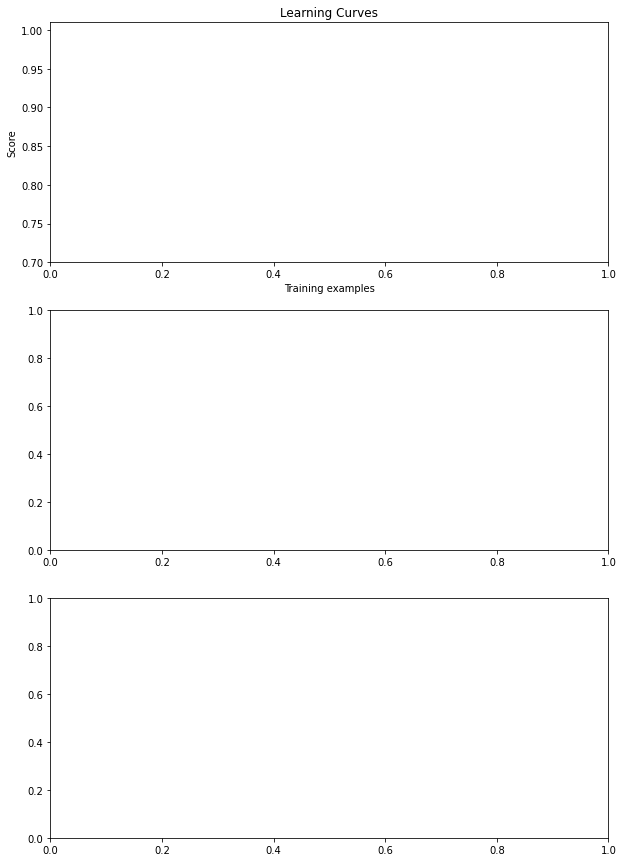

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = r"Learning Curves"
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
estimator = SVC(kernel='linear', C=1.0, probability=True)
plot_learning_curve(estimator, title, X, y, axes=axes[:], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

In [ ]:
from sklearn.svm import SVC 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from numpy import mean 
from numpy import std 

 
# build model 
clf = estimator 
 
# evaluate model 
cv = KFold(n_splits=10, random_state=1, shuffle=True) 
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
 
# report performance 
print('CV Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))